# MARCH MAMMAL MADNESS 2021
## Initialisation
**Thomas Smallwood** (tomrcsmallwood at gmail dot com)

Initialise a March Mammal Madness competition

Reads in a collates brackets submitted using google sheet found at:

Prepares collated brackets for scoring

Outputs summary visualisations:
 - Popular selections for finalists and champions
 - Pairwise comparisons of submissions

In [7]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import xkcd_palette

import os
import re

## Read in submissions

In [8]:
#Locate submitted brackets

#Set path to submissions
path = "./Submissions/"

#Create list to store submissions
filelist = []
participants = []

#For each file in path
for root, dirs, files in os.walk(path):
    for file in files:
        #If the file is a csv and has the correct name structure
        if re.match("MMM_2021_.*\.xlsx", file):
            filelist.append(os.path.join(file))
            participants.append(re.sub('Bracket[^A-Za-z0-9]+', '', re.search("Bracket_.*\.", file).group(0).strip('.')))

In [9]:
#Combine submissions

submissions = pd.read_excel(path+filelist[0], sheet_name = 'RESULTS')

submissions.rename(columns = {"Prediction" : participants[0]}, inplace = True)

for i in range(1, len(filelist)):
    submissions[participants[i]] = pd.read_excel(path+filelist[i], sheet_name = 'RESULTS').iloc[:,1]

submissions.set_index("Match", inplace = True)
display(submissions)

submissions.to_csv("Submissions/CollatedSubmissions.csv")

,Dani,Ellie,Hellen,Isla,Jamie,Phil,Tom
Match,,,,,,,
WC,Hopi Chipmunk,Southern Red-Backed Vole,Hopi Chipmunk,Southern Red-Backed Vole,Hopi Chipmunk,Hopi Chipmunk,Hopi Chipmunk
A11,Dugong,Dugong,Dugong,Dugong,Dugong,Colo Colo Opossom,Dugong
A12,Aodad,Aodad,Aodad,Aodad,Aodad,Aodad,Aoudad
A13,Egyptian Fruit Bat,Kinda Baboon,Egyptian Fruit Bat,Kinda Baboon,Kinda Baboon,Kinda Baboon,Kinda Baboon
A14,Malagasy Striped Civet,Solenodon,Malagasy Striped Civet,Malagasy Striped Civet,Malagasy Striped Civet,Malagasy Striped Civet,Malagasy Striped Civet
...,...,...,...,...,...,...,...
Q3,Harpy Eagle,Picado's Jumping Pitviper,Masrasector nananubis,Devil Frog,Masrasector nananubis,Harpy Eagle,Chimpanzee
Q4,Midgardia Seastar,Platyzilla,Platyzilla,Vampire Squid,Saber-Toothed Anchovy,Platyzilla,Platyzilla
S1,Mountain Tapir,Kinda Baboon,Jaguarundi,Dugong,Red Kangaroo,Mountain Tapir,Red Hartebeest


,CountFinalist,CountChampion,CountRunnerUp
Mountain Tapir,2,1,1
Kinda Baboon,1,1,0
Jaguarundi,1,1,0
Dugong,1,1,0
Red Kangaroo,1,0,1
Red Hartebeest,1,1,0
Harpy Eagle,2,1,1
Picado's Jumping Pitviper,1,0,1
Platyzilla,1,0,1
Devil Frog,1,0,1


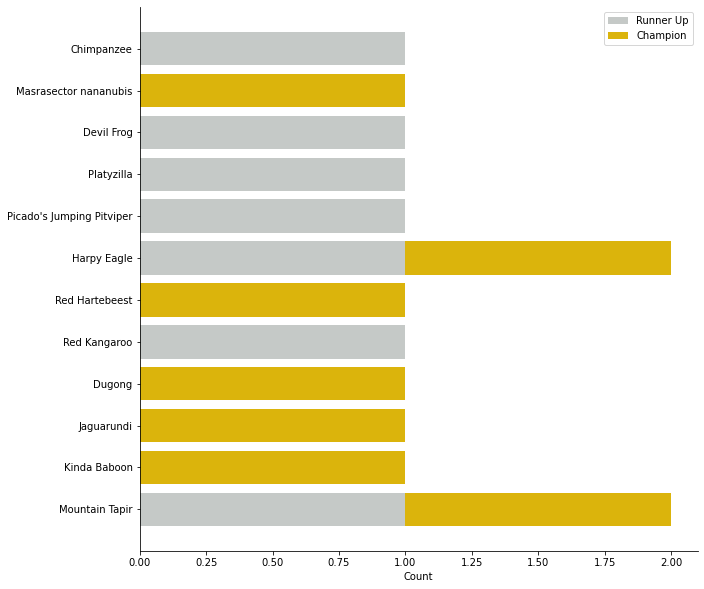

In [16]:
#Plot finalist selections

from collections import Counter

finalists = submissions.loc["S1"].to_list() + submissions.loc["S2"].to_list()

champions = submissions.loc["F"].to_list()

finals = pd.DataFrame.from_dict(Counter(finalists), orient='index')

finals.columns = ["CountFinalist"]

finals['CountChampion'] = finals.index.map(Counter(champions))

finals['CountRunnerUp'] = finals["CountFinalist"] - finals['CountChampion']

display(finals)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(111)

palette = xkcd_palette(["silver", "gold"])

ax1.barh(finals.index, finals["CountRunnerUp"], color = palette[0])

ax1.barh(finals.index, finals["CountChampion"], left = finals["CountRunnerUp"], color = palette[1])

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax1.set_xlabel("Count")
ax1.legend(labels = ["Runner Up", "Champion"], loc='upper right')

plt.show()


fig.savefig("Results/Finalists.png", bbox_inches = "tight", facecolor = "white")

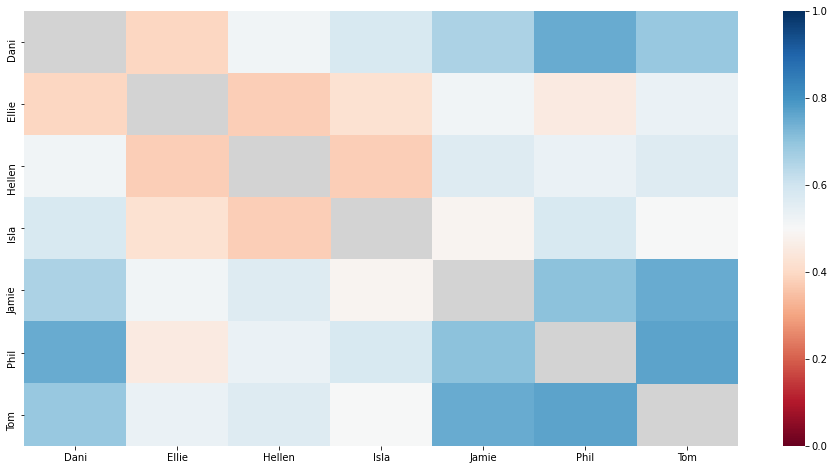

In [17]:
#Plot pairwise comparison

#Create a matrix for unweighted pairwise comparisons of predictions with named columns and rows 
sim_mat = np.ones((len(participants), )*2)

sim_points_mat = np.empty((len(participants), )*2)

#Loop through participants
for p in range(len(participants)):
  
    #Extract participants' predictions
    tmp_preds = submissions.iloc[:,p]
  
    #Loop through other participants
    for a in [a for a in range(len(participants)) if a != p]:

        #Calculate proportion of predictions which are the same and assign to matrix
        sim_mat[p,a] = (tmp_preds == submissions.iloc[:,a]).sum()/submissions.shape[0]
    
        #Calculate the proportion of predictions which are the same weighted by point value and assign to matrix
        #sim_points_mat[p,a] <- sum((tmp_preds == MMM_df[,a+4])*MMM_df$Points)/sum(MMM_df$Points)

sim_df = pd.DataFrame(sim_mat, columns = participants, index = participants)

fig = plt.figure(figsize= (16, 8))

ax = sns.heatmap(sim_df, vmax = 1, vmin = 0, cmap = "RdBu", mask = np.identity(len(participants), dtype = np.bool))
ax.set_facecolor("lightgray")

fig.savefig("Results/Similarity.png", bbox_inches = "tight", facecolor = "white")